<a href="https://colab.research.google.com/github/yylonly/ServeNet/blob/stacked-bert/ServeNet/BERT_Service_GPU_Adam_GoogleDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
!nvidia-smi

TensorFlow 2.x selected.
Sun Dec  1 21:55:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                   

In [0]:
#@title Hyberparameters:
batch_size = 64 #@param {type:"integer"}
maxLen = 110 #@param {type:"integer"}
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1" #@param ["https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"]

if bert_path == "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1":
  hiddenSize = 768
elif bert_path == "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1":
  hiddenSize = 1024

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K

print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.0.0
Hub version:  0.7.0


In [0]:
SavePrefix='BERT-Service-GPU-Adam-GoolgeDrive'

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import os

if os.path.isdir("/content/drive/My Drive/ServeNet"):
  os.chdir("/content/drive/My Drive/ServeNet")
else: 
  !git clone https://github.com/yylonly/ServeNet.git
  os.chdir("/content/drive/My Drive/ServeNet")

In [0]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  # tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

# Detect hardware
# tf.keras.backend.clear_session()

# for compatible tensorflow 2.0
# tf.compat.v1.disable_eager_execution()

# resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.contrib.distribute.initialize_tpu_system(resolver)
# strategy = tf.contrib.distribute.TPUStrategy(resolver)

Running on single GPU  /job:localhost/replica:0/task:0/device:GPU:0
Number of accelerators:  1


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import h5py
import pandas as pd
import numpy as np

#from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.initializers import Orthogonal

In [0]:
h5f = h5py.File('Data/BERT-ServiceDataset-New.h5','r') 
X_train = h5f['train_input_ids'][:8064].astype(np.int32)
X_mask_train = h5f['train_input_masks'][:8064].astype(np.int32)
X_segment_train = h5f['train_segment_ids'][:8064].astype(np.int32)
Y_train = h5f['Train_Y_one_hot'][:8064].astype(np.int32)

X_test = h5f['test_input_ids'][:2048].astype(np.int32)
X_mask_test = h5f['test_input_masks'][:2048].astype(np.int32)
X_segment_test = h5f['test_segment_ids'][:2048].astype(np.int32)
Y_test = h5f['Test_Y_one_hot'][:2048].astype(np.int32)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

step = len(X_train) // batch_size
print(step)

(8064, 110) (8064, 50)
(2048, 110) (2048, 50)
126


In [0]:
!ls -l Data

total 4144730
-rw------- 1 root root      1500 Nov 22 16:59 Attention-LSTM_acc_category.json
-rw------- 1 root root  30963456 Nov 28 18:33 BERT-ServiceDataset.h5
-rw------- 1 root root  30963456 Dec  1 20:31 BERT-ServiceDataset-New1.h5
-rw------- 1 root root  30963456 Dec  1 20:20 BERT-ServiceDataset-New.h5
-rw------- 1 root root      1470 Nov 22 16:59 BILSTM_acc_category.json
-rw------- 1 root root      3080 Nov 22 16:59 Catagories.h5
-rw------- 1 root root       806 Nov 28 18:28 category_to_index.json
-rw------- 1 root root      1485 Nov 22 16:59 CLSTM_acc_category.json
-rw------- 1 root root      1499 Nov 22 16:59 cnn_acc_category.json
-rw------- 1 root root     20730 Nov 22 16:59 Comparasion_Trans_Test_Categories_precentage.pdf
-rw------- 1 root root     20730 Nov 22 16:59 Comparasion_Trans_Test.pdf
-rw------- 1 root root 693432828 Aug  4  2014 glove.6B.200d.txt
-rw------- 1 root root     42267 Dec  1 10:23 HistogramAllCatagories.pdf
-rw------- 1 root root     17287 Dec  1 10:24 Hi

In [0]:
def ServeNet(input_shape):
    """
    Function creating the ServeNet model
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # INPUT
    in_id = Input(shape=input_shape, dtype=tf.int32, name="input_word_ids")
    in_mask = Input(shape=input_shape, dtype=tf.int32, name="input_masks")
    in_segment = Input(shape=input_shape, dtype=tf.int32, name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]

    # BERT
    bert_layer = hub.KerasLayer(bert_path, trainable=True, name="bert")
    pooled_output, _ = bert_layer(bert_inputs)
    # _, sequence_output = bert_layer(bert_inputs)

    # embeddings = Reshape((maxLen, hiddenSize, 1))(sequence_output)
    
    # # CNN
    # features1 = Conv2D(32, kernel_size=(3, 3), padding='same')(embeddings)
    # features1 = Dropout(0.2)(features1)
    # features2 = Conv2D(1, kernel_size=(1, 1), padding='same')(features1)
    # # features2 = Dropout(0.4)(features2)

    # features = Reshape((maxLen, hiddenSize))(features2)
     
    # # LSTM
    # X = Bidirectional(LSTM(384, return_sequences=False))(features)
    # X = Dropout(0.5)(X)

    # TASK 
    # X = Dense(200, activation='tanh')(X)
    X = Dropout(0.1)(pooled_output)
    X = Dense(50, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=bert_inputs, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
checkpointer = ModelCheckpoint(filepath='Data/ServeNet-' + SavePrefix + '.hdf5', monitor='val_top_k_categorical_accuracy', verbose=1, save_best_only=True)

In [0]:
adam = tf.keras.optimizers.Adam(lr=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay=0.01)
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8, nesterov=True)

In [0]:
with strategy.scope():
    model = ServeNet((maxLen, ))
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.top_k_categorical_accuracy, metrics.categorical_accuracy])

In [0]:
for layer in model.layers:
    print(layer.output_shape)
model.summary()

[(None, 110)]
[(None, 110)]
[(None, 110)]
[(None, 768), (None, None, 768)]
(None, 768)
(None, 50)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 110)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 110)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 110)]        0                                            
__________________________________________________________________________________________________
bert (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]          

In [0]:
history = model.fit([X_train, X_mask_train, X_segment_train], Y_train, validation_data=([X_test, X_mask_test, X_segment_test],  Y_test), epochs=20, steps_per_epoch=step, verbose = 1, callbacks=[checkpointer])

Train on 8064 samples, validate on 2048 samples
Epoch 1/20
8000/8064 [============================>.] - ETA: 0s - loss: 3.4923 - top_k_categorical_accuracy: 0.4538 - categorical_accuracy: 0.1975
Epoch 00001: val_top_k_categorical_accuracy improved from -inf to 0.70068, saving model to Data/ServeNet-BERT-Service-GPU-Adam-GoolgeDrive.hdf5
8064/8064 [==============================] - 128s 16ms/sample - loss: 3.4881 - top_k_categorical_accuracy: 0.4556 - categorical_accuracy: 0.1994 - val_loss: 3.0168 - val_top_k_categorical_accuracy: 0.7007 - val_categorical_accuracy: 0.3726
Epoch 2/20
8000/8064 [============================>.] - ETA: 0s - loss: 2.6963 - top_k_categorical_accuracy: 0.7749 - categorical_accuracy: 0.5005
Epoch 00002: val_top_k_categorical_accuracy improved from 0.70068 to 0.81104, saving model to Data/ServeNet-BERT-Service-GPU-Adam-GoolgeDrive.hdf5
8064/8064 [==============================] - 105s 13ms/sample - loss: 2.6944 - top_k_categorical_accuracy: 0.7749 - categorical

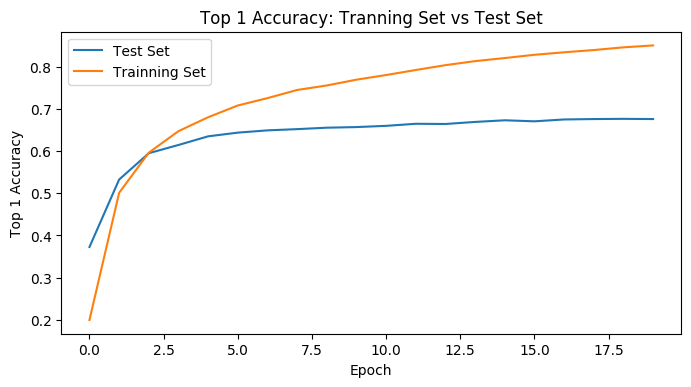

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + 'ServeNetTop1.pdf', format='pdf', dpi=300)

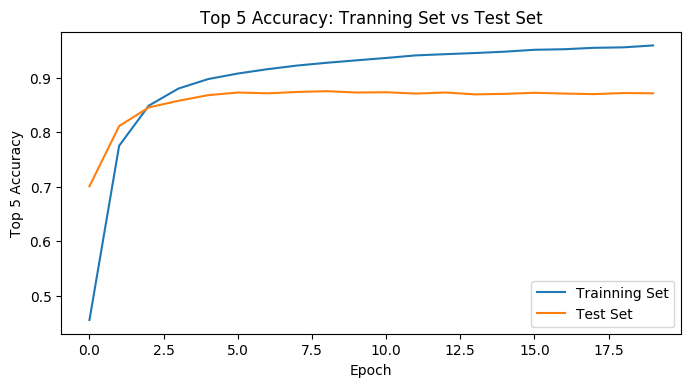

<Figure size 432x288 with 0 Axes>

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + '-ServeNetTop5.pdf', format='pdf', dpi=300)

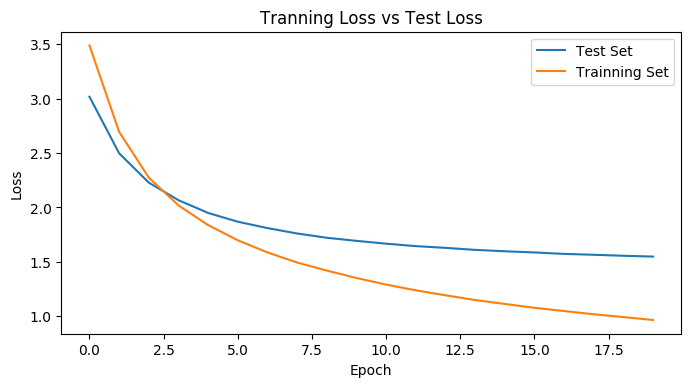

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + '-ServeNetLoss.pdf', format='pdf', dpi=300)

In [0]:
import pickle
  
f = open(SavePrefix + '-ServeNetHistory', 'wb')
pickle.dump(history.history, f)
f.close()

In [0]:
import pickle

f = open(SavePrefix + '-ServeNetHistory', 'rb')
his = pickle.load(f)
f.close()

In [0]:
val_top_k = his['val_top_k_categorical_accuracy']
print("top5: ", max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print("loss: ", min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print("top1: ", max(val_ca))
print(np.argmax(val_ca))

top5:  0.875
8
loss:  1.5479159764945507
19
top1:  0.6767578
18


In [0]:
model = load_model('Data/ServeNet-' + SavePrefix + '.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
print("Training set:")
loss_train, top5error_train, top1error_train = model.evaluate([X_train, X_mask_train, X_segment_train], Y_train)
print("Top5 Training accuracy = ", top5error_train)
print("Top1 Training accuracy = ", top1error_train)
print('Test set:')
loss_test, top5error_test, top1error_test = model.evaluate([X_test, X_mask_test, X_segment_test], Y_test)
print("Training accuracy = ", top5error_test)
print("Top1 Training accuracy = ", top1error_test)

Training set:
8064/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
{'Advertising',
 'Analytics',
 'Application Development',
 'Backend',
 'Banking',
 'Bitcoin',
 'Chat',
 'Cloud',
 'Data',
 'Database',
 'Domains',
 'Education',
 'Email',
 'Enterprise',
 'Entertainment',
 'Events',
 'File Sharing',
 'Financial',
 'Games',
 'Government',
 'Images',
 'Internet of Things',
 'Mapping',
 'Marketing',
 'Media',
 'Medical',
 'Messaging',
 'Music',
 'News Services',
 'Other',
 'Payments',
 'Photos',
 'Project Management',
 'Real Estate',
 'Reference',
 'Science',
 'Search',
 'Security',
 'Shipping',
 'Social',
 'Sports',
 'Stocks',
 'Storage',
 'Telephony',
 'Tools',
 'Transportation',
 'Travel',
 'Video',
 'Weather',
 'eCommerce'}

{'Advertising',
 'Analytics',
 'Application Development',
 'Backend',
 'Banking',
 'Bitcoin',
 'Chat',
 'Cloud',
 'Data',
 'Database',
 'Domains',
 'Education',
 'Email',
 'Enterprise',
 'Entertainment',
 'Events',
 'File Sharing',
 'Financial',
 'Games',
 'Government',
 'Images',
 'Internet of Things',
 'Mapping',
 'Marketing',
 'Media',
 'Medical',
 'Messaging',
 'Music',
 'News Services',
 'Other',
 'Payments',
 'Photos',
 'Project Management',
 'Real Estate',
 'Reference',
 'Science',
 'Search',
 'Security',
 'Shipping',
 'Social',
 'Sports',
 'Stocks',
 'Storage',
 'Telephony',
 'Tools',
 'Transportation',
 'Travel',
 'Video',
 'Weather',
 'eCommerce'}